## MFE5310 

By Linjuan 218040004


In this notebook, I use CNN、HMM and LSTM to predict the movement direction (up/down) of SSE Composite Index('000001.SS').

* Dataset: daily, SSE Composite Index('000001.SS'), from 20160101 to 20190310
<br />

* Features: 
    
    I define 3 types of features:
    
    1. Momentumn: 5-days', 10-days', 20-days' momentumn;
    
    
    2. Change intraday: 
    
    chg_intraday = (high-low)/(close-open)-1, 
    
    frac_change = (close - open) / open,
    
    frac_high = (high - open) / open，
    
    frac_low = (open - low) / open
    
    
    3. Price: OHLC, sma；
<br />

* Class imbalance checking:
    
    Positive case: Negative case =  52%:48%，which shows my dataset doesn't have class imbalance problem.
<br />

* Tune the parameters:

    CNN:
    
    batch_size = [64, 1024]
    
    epochs = [20, 50, 100]
    
    optimizer = ['SGD', 'RMSprop', 'Adam', 'Adamax', 'Nadam']
    
    learn_rate = [0.01, 0.1, 0.2, 0.3]
    
    weight initialization = ['uniform', 'lecun_uniform', 'normal', 'zero']
    
    Best parameters: {'batch_size': 1024, 'epochs': 50, 'optimizer': 'RMSprop', 'learn_rate': 0.01, 'init_mode': 'uniform'}

    
    LSTM:
    
    batch_size = [64, 256, 1024]
    
    epochs = [20, 50, 100]

    neurons = [1,10,30,60]
    
    Best parameters: {'batch_size': 32, 'epochs': 100, 'neurons':1}
    

* Conclusion:


![title](result.png)

    HMM performs the best for my dataset with the accuracy 51%, precision 51%, recall 99%, f167%,auc 50%.

### Import The Libraries

In [1]:
from pandas_datareader import data as web
import numpy as np
import pandas as pd
from sklearn import mixture as mix
import seaborn as sns 
import matplotlib.pyplot as plt
import talib as ta
from sklearn.preprocessing import StandardScaler
import fix_yahoo_finance
from sklearn import metrics

### Import The Data

Analyze SSE Composite Index('000001.SS'), from 20160101 to 20190310

In [2]:
df = web.get_data_yahoo('000001.SS',start= '2016-01-01', end='2019-03-10')

In [3]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-03-05,3054.961914,3009.447998,3019.879883,3054.247070,424100,3054.247070
2019-03-06,3103.824951,3050.111084,3060.433105,3102.099121,555000,3102.099121
2019-03-07,3129.939941,3074.978027,3103.667969,3106.417969,583800,3106.417969
2019-03-08,3075.045898,2969.582031,3038.335938,2969.861084,577900,2969.861084
2019-03-11,3028.253906,2963.583008,2969.080078,3026.992920,426200,3026.992920


### Define Features

In [145]:
adj_close = df['Adj Close']
ope      = df['Open']
close     = df['Close']
high      = df['High']
low       = df['Low']
volume    = df['Volume']


# Feature1: momentum
def calc_momentum(adj_close, window):
    return adj_close/adj_close.shift(window)-1

momentum_5  = calc_momentum(adj_close, 5 )
momentum_10 = calc_momentum(adj_close, 10)
momentum_20 = calc_momentum(adj_close, 20)

vol_ma = volume.rolling(window = 10).mean()
chg_intraday = (high-low)/(close-ope)-1
chg_intraday = chg_intraday.replace(np.inf, 0)

sma = adj_close.rolling(window = 10).mean()

frac_change = (close - ope) / ope
frac_high = (high - ope) / ope
frac_low = (ope - low) / ope

### Implement machine learning algorithms

Initialize an empty dataframe to store evaluation results.

In [264]:
col = ['Accuracy','Precision','Recall','F1','ROC/AUC']
index = ['CNN','HMM','LSTM']
result = pd.DataFrame(np.nan,index = index, columns = col)

### ========================== Convolutional Neural Network (CNN) =============================

In [6]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import roc_curve, auc, accuracy_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
import time

Using TensorFlow backend.


### Generate picture samples 

In [7]:
def scale_list(l, to_min, to_max):
    # map the number in l to [to_min, to_max]
    # step1: map the number in l to [0, 1]
    # step2: multiply the new l in step 1 by (to_max - to_min)
    def scale_number(unscaled, to_min, to_max, from_min, from_max):
        return (to_max-to_min)*(unscaled-from_min)/(from_max-from_min)+to_min

    if len(set(l)) == 1:
        return [np.floor((to_max + to_min)/2)] * len(l)
    else:
        return [scale_number(i, to_min, to_max, min(l), max(l)) for i in l]

def df2pic_join(*args):

    pic = []
    for each in args:
        height = int(len(each)/2)
        scaled_each = np.array(np.round(scale_list(each, 0, height - 1), 0))
        scaled_each = height-scaled_each-1
        blank_matrix = np.zeros(shape=(height, len(each)))
        for i,d in enumerate(scaled_each):
            blank_matrix[int(d), i] = 1

        pic.append(blank_matrix)
    return np.vstack(pic)

def df2pic_overlap(*args):
    count = 0
    df = []
    for each in args:
        count += 1
        df = df+list(each)

    width = int(len(df) / count)
    height = int(width / 2)
    scaled_df = np.array(np.round(scale_list(df, 0, height- 1), 0))
    scaled_df = height-scaled_df-1

    blank_matrix = np.zeros(shape=(height, width))
    scaled_df_val = scaled_df.reshape(width,count,order='F')
    for i in range(width):
        for c,j in enumerate(scaled_df_val[i,:]):
            blank_matrix[int(j),i] += c+1
    return blank_matrix

In [8]:
x = []
y = []
tr = 20
nDay = len(close)

for cnt in range(tr+5,nDay-1):
    if np.isnan(np.array(momentum_20[cnt-tr:cnt]+sma[cnt-tr:cnt]+
                        vol_ma[cnt - tr:cnt]+chg_intraday[cnt-tr:cnt])).any():
        continue

    pic_overlap1 = df2pic_overlap(momentum_5[cnt-tr:cnt],momentum_20[cnt-tr:cnt])
    pic_overlap2 = df2pic_overlap(volume[cnt - tr:cnt], vol_ma[cnt - tr:cnt])
        
    pic_join = df2pic_join(chg_intraday[cnt-tr:cnt])
                          

    pic = np.vstack([pic_overlap1,pic_overlap2, pic_join])
    x.append(pic)
    if len(x)%1000 ==0:
        print('length of successful samples:'+ str(len(x)))

    y.append(int(close[cnt+1]>close[cnt]))

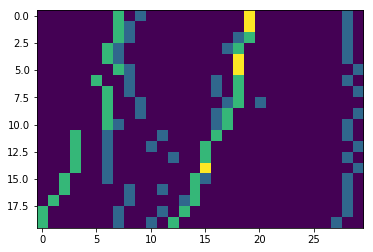

In [9]:
plt.imshow(pic.T)

### Check if the dataset has class imbalance issue

In [10]:
print('Positive case : Negative case = ',
      str(sum(y)/len(y)),':',str(1-sum(y)/len(y)))

Positive case : Negative case =  0.5367847411444142 : 0.4632152588555858


The numbers of samples in these two classes are close.

This dataset doesn't have class imbalance problem.

### Split The Dataset

In [11]:
split = int(0.7*len(x))
x_train, x_valid, y_train, y_valid = x[:split], x[split:], y[:split], y[split:]

In [12]:
# input image dimensions
img_rows, img_cols = pic.shape

# add fake depth channel
x_train_mod = np.array(x_train).reshape(np.array(x_train).shape[0], img_rows, img_cols, 1)
x_valid = np.array(x_valid).reshape(np.array(x_valid).shape[0], img_rows, img_cols, 1)

### Creat cnn model

In [38]:
from keras.optimizers import SGD

input_shape = (img_rows, img_cols, 1)
def create_cnn(optimizer='adam',init_mode='uniform',sgd=False,learn_rate=0.01):
    model = Sequential()
    model.add(Conv2D(64, (5, 5), input_shape=input_shape, activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
#     model.add(Conv2D(10, (2, 2), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, kernel_initializer=init_mode, activation='relu'))
#     model.add(Dense(50, kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    if sgd:
        optimizer = SGD(lr=learn_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

### Tune parameters

In [39]:
import warnings
warnings.filterwarnings("ignore")

In [40]:
def grid_search(model, param_grid, x_train, mode=0):
    if mode==0:
        # Normal cv
        cv_str = 'Normal cv'
        cur_cv = 5
        
    elif mode==1:
        # TimeSeriesSplit cv
        cv_str = 'TimeSeriesSplit cv'
        cur_cv = TimeSeriesSplit(n_splits=4).split(x_train)
        
    elif mode==2:
        # TimeSeriesSplit cross validation with a fixed training size
        cv_str = 'TimeSeriesSplit cv (fixed)'
        cur_cv = TimeSeriesSplit(n_splits=4, max_train_size=int(len(x_train)/5*4)).split(x_train)
        
    clf = GridSearchCV(estimator=model, param_grid=param_grid, cv=cur_cv,
                       scoring='precision', n_jobs=-1)
    return cv_str,clf
                
    
def grid_results_summary(grid_result):
    print("\n Best parameters set found on development set: \n")
    
    print(grid_result.best_params_)
    print("\n Grid scores on development set: \n")
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid_result.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
                % (mean, std * 2, params))

    print("\n Detailed classification report:\n")
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.\n") 

* tune batch_size and epochs
    
    Normal cross validation

In [41]:
model = KerasClassifier(build_fn=create_cnn, verbose=0)

batch_size = [64, 1024]
epochs = [20, 50, 100]

param_grid = dict(batch_size=batch_size, epochs=epochs)

cv_str, clf = grid_search(model, param_grid, x_train_mod, mode=0)

In [42]:
tic = time.time()
grid_result = clf.fit(x_train_mod, y_train)
toc = time.time()
print('\n' + cv_str +'\n')
print('cross validation time: '+str((toc-tic)/60)+'minuts')
grid_results_summary(grid_result)


Normal cv

cross validation time: 11.935525385538737minuts

 Best parameters set found on development set: 

{'batch_size': 64, 'epochs': 50}

 Grid scores on development set: 

0.570 (+/-0.015) for {'batch_size': 64, 'epochs': 20}
0.600 (+/-0.041) for {'batch_size': 64, 'epochs': 50}
0.598 (+/-0.082) for {'batch_size': 64, 'epochs': 100}
0.557 (+/-0.050) for {'batch_size': 1024, 'epochs': 20}
0.571 (+/-0.111) for {'batch_size': 1024, 'epochs': 50}
0.596 (+/-0.067) for {'batch_size': 1024, 'epochs': 100}

 Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



In [43]:
y_true, y_pred = y_valid, grid_result.predict(x_valid)
print(metrics.classification_report(y_true, y_pred))
print('Accuracy: '+ str(metrics.accuracy_score(y_true, y_pred))+'\n')
print('Precision: ' + str(metrics.average_precision_score(y_true, y_pred))+'\n')
print('Recall: ' + str(metrics.recall_score(y_true, y_pred)) +'\n')
print('F1 score: '+ str(metrics.f1_score(y_true, y_pred))+'\n')
print('ROC/AUC: '+ str(metrics.roc_auc_score(y_true, y_pred))+'\n')

              precision    recall  f1-score   support

           0       0.61      0.36      0.46       118
           1       0.50      0.73      0.59       103

   micro avg       0.53      0.53      0.53       221
   macro avg       0.55      0.55      0.52       221
weighted avg       0.56      0.53      0.52       221

Accuracy: 0.5339366515837104

Precision: 0.49077450248209814

Recall: 0.7281553398058253

F1 score: 0.592885375494071

ROC/AUC: 0.5462810597334211



* tune batch_size and epochs
    
    TimeSeriesSplit cross validation

In [44]:
cv_str, clf = grid_search(model, param_grid, x_train_mod, mode=1)
tic = time.time()
grid_result = clf.fit(x_train_mod, y_train)
toc = time.time()
print('\n' + cv_str +'\n')
print('cross validation time: '+str((toc-tic)/60)+'minuts')
grid_results_summary(grid_result)


TimeSeriesSplit cv

cross validation time: 5.542277149359385minuts

 Best parameters set found on development set: 

{'batch_size': 1024, 'epochs': 50}

 Grid scores on development set: 

0.588 (+/-0.040) for {'batch_size': 64, 'epochs': 20}
0.597 (+/-0.074) for {'batch_size': 64, 'epochs': 50}
0.578 (+/-0.063) for {'batch_size': 64, 'epochs': 100}
0.587 (+/-0.052) for {'batch_size': 1024, 'epochs': 20}
0.612 (+/-0.081) for {'batch_size': 1024, 'epochs': 50}
0.600 (+/-0.066) for {'batch_size': 1024, 'epochs': 100}

 Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



In [45]:
y_true, y_pred = y_valid, grid_result.predict(x_valid)
print(metrics.classification_report(y_true, y_pred))
print('Accuracy: '+ str(metrics.accuracy_score(y_true, y_pred))+'\n')
print('Precision: ' + str(metrics.average_precision_score(y_true, y_pred))+'\n')
print('Recall: ' + str(metrics.recall_score(y_true, y_pred)) +'\n')
print('F1 score: '+ str(metrics.f1_score(y_true, y_pred))+'\n')
print('ROC/AUC: '+ str(metrics.roc_auc_score(y_true, y_pred))+'\n')

              precision    recall  f1-score   support

           0       0.55      0.35      0.43       118
           1       0.48      0.68      0.56       103

   micro avg       0.50      0.50      0.50       221
   macro avg       0.52      0.51      0.49       221
weighted avg       0.52      0.50      0.49       221

Accuracy: 0.502262443438914

Precision: 0.4729458624375814

Recall: 0.6796116504854369

F1 score: 0.5599999999999999

ROC/AUC: 0.5135346388020405



* tune batch_size and epochs
    
    TimeSeriesSplit cross validation with a fixed training size

In [46]:
cv_str, clf = grid_search(model, param_grid, x_train_mod, mode=2)
tic = time.time()
grid_result = clf.fit(x_train_mod, y_train)
toc = time.time()
print('\n' + cv_str +'\n')
print('cross validation time: '+str((toc-tic)/60)+'minuts')
grid_results_summary(grid_result)


TimeSeriesSplit cv (fixed)

cross validation time: 5.530984882513682minuts

 Best parameters set found on development set: 

{'batch_size': 1024, 'epochs': 50}

 Grid scores on development set: 

0.605 (+/-0.072) for {'batch_size': 64, 'epochs': 20}
0.598 (+/-0.065) for {'batch_size': 64, 'epochs': 50}
0.604 (+/-0.099) for {'batch_size': 64, 'epochs': 100}
0.566 (+/-0.104) for {'batch_size': 1024, 'epochs': 20}
0.606 (+/-0.048) for {'batch_size': 1024, 'epochs': 50}
0.592 (+/-0.068) for {'batch_size': 1024, 'epochs': 100}

 Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



In [47]:
y_true, y_pred = y_valid, grid_result.predict(x_valid)
print(metrics.classification_report(y_true, y_pred))
print('Accuracy: '+ str(metrics.accuracy_score(y_true, y_pred))+'\n')
print('Precision: ' + str(metrics.average_precision_score(y_true, y_pred))+'\n')
print('Recall: ' + str(metrics.recall_score(y_true, y_pred)) +'\n')
print('F1 score: '+ str(metrics.f1_score(y_true, y_pred))+'\n')
print('ROC/AUC: '+ str(metrics.roc_auc_score(y_true, y_pred))+'\n')

              precision    recall  f1-score   support

           0       0.54      0.38      0.45       118
           1       0.47      0.63      0.54       103

   micro avg       0.50      0.50      0.50       221
   macro avg       0.51      0.51      0.49       221
weighted avg       0.51      0.50      0.49       221

Accuracy: 0.497737556561086

Precision: 0.4691878569786846

Recall: 0.6310679611650486

F1 score: 0.5394190871369294

ROC/AUC: 0.5062119466842192



* tune optimizer

    TimeSeriesSplit cross validation

In [48]:
model = KerasClassifier(build_fn=create_cnn, epochs=50, batch_size=1024, verbose=0)
optimizer = ['SGD', 'RMSprop', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)

In [49]:
cv_str, clf = grid_search(model, param_grid, x_train_mod, mode=1)
tic = time.time()
grid_result = clf.fit(x_train_mod, y_train)
toc = time.time()
print('\n' + cv_str +'\n')
print('cross validation time: '+str((toc-tic)/60)+'minuts')
grid_results_summary(grid_result)


TimeSeriesSplit cv

cross validation time: 4.320262495676676minuts

 Best parameters set found on development set: 

{'optimizer': 'RMSprop'}

 Grid scores on development set: 

0.583 (+/-0.062) for {'optimizer': 'SGD'}
0.603 (+/-0.073) for {'optimizer': 'RMSprop'}
0.593 (+/-0.046) for {'optimizer': 'Adam'}
0.586 (+/-0.045) for {'optimizer': 'Adamax'}
0.586 (+/-0.054) for {'optimizer': 'Nadam'}

 Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



In [50]:
y_true, y_pred = y_valid, grid_result.predict(x_valid)
print(metrics.classification_report(y_true, y_pred))
print('Accuracy: '+ str(metrics.accuracy_score(y_true, y_pred))+'\n')
print('Precision: ' + str(metrics.average_precision_score(y_true, y_pred))+'\n')
print('Recall: ' + str(metrics.recall_score(y_true, y_pred)) +'\n')
print('F1 score: '+ str(metrics.f1_score(y_true, y_pred))+'\n')
print('ROC/AUC: '+ str(metrics.roc_auc_score(y_true, y_pred))+'\n')

              precision    recall  f1-score   support

           0       0.55      0.19      0.29       118
           1       0.47      0.82      0.60       103

   micro avg       0.48      0.48      0.48       221
   macro avg       0.51      0.51      0.44       221
weighted avg       0.51      0.48      0.43       221

Accuracy: 0.4841628959276018

Precision: 0.4686815343040517

Recall: 0.8155339805825242

F1 score: 0.5957446808510638

ROC/AUC: 0.5052246174099062



* tune learning rate

    TimeSeriesSplit cross validation

In [51]:
model = KerasClassifier(build_fn=create_cnn, epochs=50, batch_size=1024, sgd=True, verbose=0)

learn_rate = [0.01, 0.1, 0.2, 0.3]
param_grid = dict(learn_rate=learn_rate)

In [52]:
cv_str, clf = grid_search(model, param_grid, x_train_mod, mode=1)
tic = time.time()
grid_result = clf.fit(x_train_mod, y_train)
toc = time.time()
print('\n' + cv_str +'\n')
print('cross validation time: '+str((toc-tic)/60)+'minuts')
grid_results_summary(grid_result)


TimeSeriesSplit cv

cross validation time: 3.4185622493426004minuts

 Best parameters set found on development set: 

{'learn_rate': 0.01}

 Grid scores on development set: 

0.587 (+/-0.046) for {'learn_rate': 0.01}
0.429 (+/-0.499) for {'learn_rate': 0.1}
0.296 (+/-0.593) for {'learn_rate': 0.2}
0.140 (+/-0.484) for {'learn_rate': 0.3}

 Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



In [53]:
y_true, y_pred = y_valid, grid_result.predict(x_valid)
print(metrics.classification_report(y_true, y_pred))
print('Accuracy: '+ str(metrics.accuracy_score(y_true, y_pred))+'\n')
print('Precision: ' + str(metrics.average_precision_score(y_true, y_pred))+'\n')
print('Recall: ' + str(metrics.recall_score(y_true, y_pred)) +'\n')
print('F1 score: '+ str(metrics.f1_score(y_true, y_pred))+'\n')
print('ROC/AUC: '+ str(metrics.roc_auc_score(y_true, y_pred))+'\n')

              precision    recall  f1-score   support

           0       0.60      0.05      0.09       118
           1       0.47      0.96      0.63       103

   micro avg       0.48      0.48      0.48       221
   macro avg       0.53      0.51      0.36       221
weighted avg       0.54      0.48      0.34       221

Accuracy: 0.4751131221719457

Precision: 0.46907272194650296

Recall: 0.9611650485436893

F1 score: 0.6305732484076433

ROC/AUC: 0.506006253085404



* tune weight initialization

    TimeSeriesSplit cross validation

In [54]:
model = KerasClassifier(build_fn=create_cnn, epochs=50, batch_size=1024, sgd=True, verbose=0)
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero']
param_grid = dict(init_mode=init_mode)

In [55]:
cv_str, clf = grid_search(model, param_grid, x_train_mod, mode=1)
tic = time.time()
grid_result = clf.fit(x_train_mod, y_train)
toc = time.time()
print('\n' + cv_str +'\n')
print('cross validation time: '+str((toc-tic)/60)+'minuts')
grid_results_summary(grid_result)


TimeSeriesSplit cv

cross validation time: 3.6389451662699384minuts

 Best parameters set found on development set: 

{'init_mode': 'uniform'}

 Grid scores on development set: 

0.583 (+/-0.061) for {'init_mode': 'uniform'}
0.581 (+/-0.047) for {'init_mode': 'lecun_uniform'}
0.577 (+/-0.064) for {'init_mode': 'normal'}
0.576 (+/-0.053) for {'init_mode': 'zero'}

 Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



In [56]:
y_true, y_pred = y_valid, grid_result.predict(x_valid)
print(metrics.classification_report(y_true, y_pred))
print('Accuracy: '+ str(metrics.accuracy_score(y_true, y_pred))+'\n')
print('Precision: ' + str(metrics.average_precision_score(y_true, y_pred))+'\n')
print('Recall: ' + str(metrics.recall_score(y_true, y_pred)) +'\n')
print('F1 score: '+ str(metrics.f1_score(y_true, y_pred))+'\n')
print('ROC/AUC: '+ str(metrics.roc_auc_score(y_true, y_pred))+'\n')

              precision    recall  f1-score   support

           0       0.71      0.04      0.08       118
           1       0.47      0.98      0.64       103

   micro avg       0.48      0.48      0.48       221
   macro avg       0.59      0.51      0.36       221
weighted avg       0.60      0.48      0.34       221

Accuracy: 0.4796380090497738

Precision: 0.4718480679213398

Recall: 0.9805825242718447

F1 score: 0.6372239747634069

ROC/AUC: 0.5114777028138884



* Cross validation summary:

    The best parameters we found: 
    
    {'batch_size': 1024, 'epochs': 50, 'optimizer': 'RMSprop', 'learn_rate': 0.01, 'init_mode': 'uniform'}

In [265]:
model_str = 'CNN'
result.loc[model_str,'Accuracy']  = metrics.accuracy_score(y_true, y_pred)
result.loc[model_str,'Precision'] = metrics.average_precision_score(y_true, y_pred)
result.loc[model_str,'Recall']    = metrics.recall_score(y_true, y_pred)
result.loc[model_str,'F1']        = metrics.f1_score(y_true, y_pred)
result.loc[model_str,'ROC/AUC']   = metrics.roc_auc_score(y_true, y_pred)

### ========================== Hidden Markov Model (HMM) =============================

In [235]:
df_hmm = np.column_stack((frac_change, frac_high, frac_low))
target_hmm = frac_change.shift(-1)

### Split The Dataset

In [248]:
split = int(0.7*len(df_hmm))
x_train, x_valid, y_valid = df_hmm[:split], df_hmm[split:], target_hmm[split:]

### creat and train HMM 

In [249]:
from hmmlearn.hmm import GaussianHMM
n_hidden_states = 8
hmm = GaussianHMM(n_components=n_hidden_states)
hmm.fit(x_train)

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=8, n_iter=10, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)

### make prediction

In [250]:
import itertools
def compute_all_possible_outcomes(n_steps_frac_change=50,
                                    n_steps_frac_high=10, n_steps_frac_low=10):
    frac_change_range = np.linspace(-0.1, 0.1, n_steps_frac_change)
    frac_high_range = np.linspace(0, 0.1, n_steps_frac_high)
    frac_low_range = np.linspace(0, 0.1, n_steps_frac_low)

    return np.array(list(itertools.product(frac_change_range, frac_high_range, frac_low_range)))

def get_most_probable_outcome(df_test,day_index,n_latency_days=5):
    previous_data_start_index = max(0, day_index - n_latency_days)
    previous_data_end_index = max(0, day_index - 1)
    
    previous_data_features = df_test[previous_data_start_index:previous_data_end_index]

    outcome_score = []
    possible_outcomes = compute_all_possible_outcomes()
    for possible_outcome in possible_outcomes:
        total_data = np.row_stack((previous_data_features, possible_outcome))
        outcome_score.append(hmm.score(total_data))
        
    most_probable_outcome = possible_outcomes[np.argmax(outcome_score)]

    return most_probable_outcome

predicted_frac_change = []
for day in range(len(x_valid)):
    predicted_frac_change.append(get_most_probable_outcome(x_valid,day)[0])

In [259]:
y_pred = [int(i>0) for i in predicted_frac_change]
y_true = [int(i>0) for i in y_valid]

In [260]:
print(metrics.classification_report(y_true, y_pred))
print('Accuracy: '+ str(metrics.accuracy_score(y_true, y_pred))+'\n')
print('Precision: ' + str(metrics.average_precision_score(y_true, y_pred))+'\n')
print('Recall: ' + str(metrics.recall_score(y_true, y_pred)) +'\n')
print('F1 score: '+ str(metrics.f1_score(y_true, y_pred))+'\n')
print('ROC/AUC: '+ str(metrics.roc_auc_score(y_true, y_pred))+'\n')

              precision    recall  f1-score   support

           0       0.50      0.01      0.02       115
           1       0.51      0.99      0.67       118

   micro avg       0.51      0.51      0.51       233
   macro avg       0.50      0.50      0.34       233
weighted avg       0.50      0.51      0.35       233

Accuracy: 0.5064377682403434

Precision: 0.5064930341354288

Recall: 0.9915254237288136

F1 score: 0.6704871060171919

ROC/AUC: 0.5001105379513633



In [266]:
model_str = 'HMM'
result.loc[model_str,'Accuracy']  = metrics.accuracy_score(y_true, y_pred)
result.loc[model_str,'Precision'] = metrics.average_precision_score(y_true, y_pred)
result.loc[model_str,'Recall']    = metrics.recall_score(y_true, y_pred)
result.loc[model_str,'F1']        = metrics.f1_score(y_true, y_pred)
result.loc[model_str,'ROC/AUC']   = metrics.roc_auc_score(y_true, y_pred)

### ========================== Long Short Term Memory (LSTM) =============================

In [57]:
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

### Feature Scaling

In [62]:
lstm_df = df[['Open']]
sc = MinMaxScaler(feature_range = (0, 1))
lstm_df_scaled = sc.fit_transform(lstm_df)

### Split The Dataset

In [201]:
split = int(0.7*len(lstm_df_scaled))
x_train, x_valid = lstm_df_scaled[:split], lstm_df_scaled[split:]

In [261]:
def generate_lstm_df(df, lookback=60):
    X = []
    y = []
    for i in range(lookback, len(df)):
        X.append(df[i - lookback:i, 0])
        y.append(np.where(df[i, 0]>df[i-1, 0],1,0))
#         y.append(np.where(df[i, 0]>df[i-1, 0],1,0))
    X, y = np.array(X), np.array(y)

    # Reshaping
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    return X, y

In [262]:
x_train_lstm,y_train_lstm = generate_lstm_df(x_train, 60)
# y_train_lstm = keras.utils.to_categorical(y_train_lstm, 2)

### Check if the dataset has class imbalance issue

In [263]:
print('Positive case : Negative case = ',
      str(sum(y_train_lstm==1)/len(y_train_lstm)),':',str(sum(y_train_lstm==0)/len(y_train_lstm)))

Positive case : Negative case =  0.48132780082987553 : 0.5186721991701245


The numbers of samples in these two classes are close. 

This dataset doesn't have class imbalance problem.

### Creat lstm model

In [209]:
input_shape = (x_train.shape[1]-60, 1)

def create_lstm(neurons=60):
    
    model = Sequential()
    model.add(Dense(neurons, kernel_initializer='uniform', 
                    activation='linear'))
    model.add(LSTM(units = 50, return_sequences = True, input_shape = input_shape))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    
#     model.add(Dense(units = 1))
    # use lstm to predict stock movement direction (up/down)
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics=['accuracy'])
    
    return model

### Tune the parameters

* tune batch_size and epochs
    
    Normal cross validation

In [176]:
model = KerasClassifier(build_fn=create_lstm, verbose=0)

batch_size = [64, 256, 1024]
epochs = [20, 50, 100]

param_grid = dict(batch_size=batch_size, epochs=epochs)

cv_str, clf = grid_search(model, param_grid, x_train, mode=0)

In [177]:
tic = time.time()
grid_result = clf.fit(x_train_lstm,y_train_lstm)
toc = time.time()
print('\n' + cv_str +'\n')
print('cross validation time: '+str((toc-tic)/60)+'minuts')
grid_results_summary(grid_result)


Normal cv

cross validation time: 11.216258915265401minuts

 Best parameters set found on development set: 

{'batch_size': 32, 'epochs': 50}

 Grid scores on development set: 

0.000 (+/-0.000) for {'batch_size': 32, 'epochs': 50}
0.000 (+/-0.000) for {'batch_size': 32, 'epochs': 100}
0.000 (+/-0.000) for {'batch_size': 256, 'epochs': 50}
0.000 (+/-0.000) for {'batch_size': 256, 'epochs': 100}
0.000 (+/-0.000) for {'batch_size': 1024, 'epochs': 50}
0.000 (+/-0.000) for {'batch_size': 1024, 'epochs': 100}

 Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



In [172]:
x_valid_lstm, y_valid_lstm = generate_lstm_df(x_valid)
y_valid_lstm = keras.utils.to_categorical(y_valid_lstm, 2)

In [178]:
y_true, y_pred = y_valid_lstm, grid_result.predict(x_valid_lstm)
print(metrics.classification_report(y_true, y_pred))
print('Accuracy: '+ str(metrics.accuracy_score(y_true, y_pred))+'\n')
print('Precision: ' + str(metrics.average_precision_score(y_true, y_pred))+'\n')
print('Recall: ' + str(metrics.recall_score(y_true, y_pred)) +'\n')
print('F1 score: '+ str(metrics.f1_score(y_true, y_pred))+'\n')
print('ROC/AUC: '+ str(metrics.roc_auc_score(y_true, y_pred))+'\n')

              precision    recall  f1-score   support

          -1       0.52      1.00      0.68       104
           1       0.00      0.00      0.00        97

   micro avg       0.52      0.52      0.52       201
   macro avg       0.26      0.50      0.34       201
weighted avg       0.27      0.52      0.35       201

Accuracy: 0.5174129353233831

Precision: 0.48258706467661694

Recall: 0.0

F1 score: 0.0

ROC/AUC: 0.5



* tune batch_size and epochs
    
    TimeSeriesSplit cross validation

In [129]:
cv_str, clf = grid_search(model, param_grid, x_train_lstm, mode=1)
tic = time.time()
grid_result = clf.fit(x_train_lstm,y_train_lstm)
toc = time.time()
print('\n' + cv_str +'\n')
print('cross validation time: '+str((toc-tic)/60)+'minuts')
grid_results_summary(grid_result)


TimeSeriesSplit cv

cross validation time: 7.634357198079427minuts

 Best parameters set found on development set: 

{'batch_size': 32, 'epochs': 50}

 Grid scores on development set: 

0.417 (+/-0.482) for {'batch_size': 32, 'epochs': 10}
0.547 (+/-0.043) for {'batch_size': 32, 'epochs': 50}
0.547 (+/-0.043) for {'batch_size': 32, 'epochs': 100}
0.000 (+/-0.000) for {'batch_size': 256, 'epochs': 10}
0.547 (+/-0.043) for {'batch_size': 256, 'epochs': 50}
0.547 (+/-0.043) for {'batch_size': 256, 'epochs': 100}
0.000 (+/-0.000) for {'batch_size': 1024, 'epochs': 10}
0.547 (+/-0.043) for {'batch_size': 1024, 'epochs': 50}
0.547 (+/-0.043) for {'batch_size': 1024, 'epochs': 100}

 Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



In [131]:
y_true, y_pred = y_valid, grid_result.predict(x_valid_lstm)
print(metrics.classification_report(y_true, y_pred))
print('Accuracy: '+ str(metrics.accuracy_score(y_true, y_pred))+'\n')
print('Precision: ' + str(metrics.average_precision_score(y_true, y_pred))+'\n')
print('Recall: ' + str(metrics.recall_score(y_true, y_pred)) +'\n')
print('F1 score: '+ str(metrics.f1_score(y_true, y_pred))+'\n')
print('ROC/AUC: '+ str(metrics.roc_auc_score(y_true, y_pred))+'\n')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       109
           1       0.46      1.00      0.63        92

   micro avg       0.46      0.46      0.46       201
   macro avg       0.23      0.50      0.31       201
weighted avg       0.21      0.46      0.29       201

Accuracy: 0.4577114427860697

Precision: 0.4577114427860697

Recall: 1.0

F1 score: 0.6279863481228669

ROC/AUC: 0.5



* tune batch_size and epochs
    
    TimeSeriesSplit cross validation with a fixed training size

In [134]:
cv_str, clf = grid_search(model, param_grid, x_train_lstm, mode=2)
tic = time.time()
grid_result = clf.fit(x_train_lstm,y_train_lstm)
toc = time.time()
print('\n' + cv_str +'\n')
print('cross validation time: '+str((toc-tic)/60)+'minuts')
grid_results_summary(grid_result)


TimeSeriesSplit cv (fixed)

cross validation time: 8.00506525039673minuts

 Best parameters set found on development set: 

{'batch_size': 32, 'epochs': 100}

 Grid scores on development set: 

0.272 (+/-0.545) for {'batch_size': 32, 'epochs': 50}
0.547 (+/-0.043) for {'batch_size': 32, 'epochs': 100}
0.403 (+/-0.466) for {'batch_size': 256, 'epochs': 50}
0.403 (+/-0.466) for {'batch_size': 256, 'epochs': 100}
0.547 (+/-0.043) for {'batch_size': 1024, 'epochs': 50}
0.547 (+/-0.043) for {'batch_size': 1024, 'epochs': 100}

 Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



In [136]:
y_true, y_pred = y_valid, grid_result.predict(x_valid_lstm)
print(metrics.classification_report(y_true, y_pred))
print('Accuracy: '+ str(metrics.accuracy_score(y_true, y_pred))+'\n')
print('Precision: ' + str(metrics.average_precision_score(y_true, y_pred))+'\n')
print('Recall: ' + str(metrics.recall_score(y_true, y_pred)) +'\n')
print('F1 score: '+ str(metrics.f1_score(y_true, y_pred))+'\n')
print('ROC/AUC: '+ str(metrics.roc_auc_score(y_true, y_pred))+'\n')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       109
           1       0.46      1.00      0.63        92

   micro avg       0.46      0.46      0.46       201
   macro avg       0.23      0.50      0.31       201
weighted avg       0.21      0.46      0.29       201

Accuracy: 0.4577114427860697

Precision: 0.4577114427860697

Recall: 1.0

F1 score: 0.6279863481228669

ROC/AUC: 0.5



* tune lookback window size

    TimeSeriesSplit cross validation

In [137]:
model = KerasClassifier(build_fn=create_lstm, epochs=100, batch_size=1024, verbose=0)
neurons = [1,10,30,60]
param_grid = dict(neurons=neurons)

In [139]:
cv_str, clf = grid_search(model, param_grid, x_train_lstm, mode=1)
tic = time.time()
grid_result = clf.fit(x_train_lstm,y_train_lstm)
toc = time.time()
print('\n' + cv_str +'\n')
print('cross validation time: '+str((toc-tic)/60)+'minuts')
grid_results_summary(grid_result)


TimeSeriesSplit cv

cross validation time: 3.0309064547220865minuts

 Best parameters set found on development set: 

{'neurons': 1}

 Grid scores on development set: 

0.547 (+/-0.043) for {'neurons': 1}
0.547 (+/-0.043) for {'neurons': 2}
0.547 (+/-0.043) for {'neurons': 3}

 Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



In [140]:
y_true, y_pred = y_valid, grid_result.predict(x_valid_lstm)
print(metrics.classification_report(y_true, y_pred))
print('Accuracy: '+ str(metrics.accuracy_score(y_true, y_pred))+'\n')
print('Precision: ' + str(metrics.average_precision_score(y_true, y_pred))+'\n')
print('Recall: ' + str(metrics.recall_score(y_true, y_pred)) +'\n')
print('F1 score: '+ str(metrics.f1_score(y_true, y_pred))+'\n')
print('ROC/AUC: '+ str(metrics.roc_auc_score(y_true, y_pred))+'\n')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       109
           1       0.46      1.00      0.63        92

   micro avg       0.46      0.46      0.46       201
   macro avg       0.23      0.50      0.31       201
weighted avg       0.21      0.46      0.29       201

Accuracy: 0.4577114427860697

Precision: 0.4577114427860697

Recall: 1.0

F1 score: 0.6279863481228669

ROC/AUC: 0.5



* Cross validation summary:

    The best parameters we found: 
    
    {'batch_size': 32, 'epochs': 100, 'neurons':1}

### Visualize Model Training History

In [108]:
def visualize_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [142]:
model = create_lstm(neurons=1)
history = model.fit(x_train_lstm,y_train_lstm,epochs = 100, batch_size = 32,
                    validation_split=0.33, verbose=0)

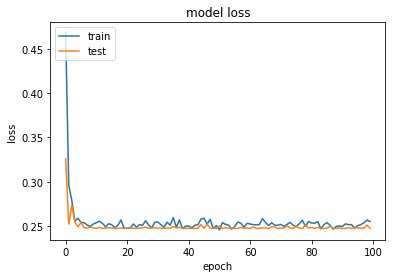

In [143]:
visualize_loss(history)

In [267]:
model_str = 'LSTM'
result.loc[model_str,'Accuracy']  = metrics.accuracy_score(y_true, y_pred)
result.loc[model_str,'Precision'] = metrics.average_precision_score(y_true, y_pred)
result.loc[model_str,'Recall']    = metrics.recall_score(y_true, y_pred)
result.loc[model_str,'F1']        = metrics.f1_score(y_true, y_pred)
result.loc[model_str,'ROC/AUC']   = metrics.roc_auc_score(y_true, y_pred)

### conclusion

In [268]:
print(result)

      Accuracy  Precision  Recall      F1  ROC/AUC
CNN     0.4796     0.4718  0.9806  0.6372   0.5115
HMM     0.5064     0.5069  0.9915  0.6705   0.5002
LSTM    0.4577     0.4577  1.0000  0.6280   0.5000


HMM performs the best for my dataset (daily, SSE Composite Index('000001.SS'), from 20160101 to 20190310) with the accuracy 51%, precision 51%, recall 99%, f167%,auc 50%.

linjuan 20190508